# Advance Dataframes

In this lesson, we will continue working with pandas dataframes, and explore some more complex dataframe manupulations. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

np.random.seed(123)

students = ['Sally', 'Jane', 'Suzie', 'Billy', 'Ada', 'John', 'Thomas',
            'Marie', 'Albert', 'Richard', 'Isaac', 'Alan']

# randomly generate scores for each student for each subject
# note that all the values need to have the same length here
math_grades = np.random.randint(low=60, high=100, size=len(students))
english_grades = np.random.randint(low=60, high=100, size=len(students))
reading_grades = np.random.randint(low=60, high=100, size=len(students))

df = pd.DataFrame({'name': students,
                   'math': math_grades,
                   'english': english_grades,
                   'reading': reading_grades,
                   'classroom': np.random.choice(['A', 'B'], len(students))})

## Creating Dataframes

**From Lists and Dictionaries

There are several ways to create dataframes, we've already seen how we can create a dataframe from a dictionary:

In [2]:
pd.DataFrame({"A": [1,2,3], "B": [4,5,6]})

,A,B
0,1,4
1,2,5
2,3,6


The keys in the passed dictionary will be the column names, and the values are the data points that make up each column. 

We can also create dataframes from a 2D data structure, either a numpy array or a list of lists:

In [3]:
pd.DataFrame([[1,2,3],[4,5,6]])

,0,1,2
0,1,2,3
1,4,5,6


In [4]:
data = np.array([[1,2,3], [4,5,6]])

pd.DataFrame(data, columns=["a","b","c"])

,a,b,c
0,1,2,3
1,4,5,6


**From Text Files**

The most commonly used function to data from an external text file is `read_csv`. Two other commonly used functions are `read_table`, for less structured files that are still tabular, and `read_json`, for data stored as JSON.

There are many other `read_` functions, but `read_csv` will be the most commonly used one. 

**From SQL**

We can use the `read_sql` method to create a dataframe based on the results of a SQL query. To do this, we need t otell pandas how t oconnect to the database we are querying. The way we communicate this to pandas is with a specially formatted *connection string*.

In addition, whenever we want to connect to a database from our python code (other programming languages are similar), we need a **driver**, a bit of software that handles the details of the database connection.

In order to connect to mysql, we'll install the `mysqlclient` and `pymysql` driver packages: python -m pip instal mysqlclient pymysql. Once those are installed, we can create the connection string. In general, database connection urls will have this format:

In [5]:
# protocol://[user[:password]@]hostname/[database_name]

Here's an example of what one would look like:

In [6]:
# mysql+pymysql://codeup:p@assw0rd@123.123.123.123/some_db

Another thing we need to consider is that we don't want to publish our database crendentials to github, however, we will need access to these values in our code in order to create a connection string defined above. 

In order to accomplish this, we can define several variables in a file named `env.py` that contain the sensitive data, add `env.py` to our `gitignore` file, and then import those values into another script.

In [7]:
from env import host, user, password

url = f'mysql+pymysql://{user}:{password}@{host}/employees'

Once this url is defined, we can use it with the `read_sql` function to have pandas treat the results of a SQL query as a dataframe.

In [8]:
pd.read_sql('SELECT * FROM employees LIMIT 5 OFFSET 50', url)

,emp_no,birth_date,first_name,last_name,gender,hire_date
0,10051,1953-07-28,Hidefumi,Caine,M,1992-10-15
1,10052,1961-02-26,Heping,Nitsch,M,1988-05-21
2,10053,1954-09-13,Sanjiv,Zschoche,F,1986-02-04
3,10054,1957-04-04,Mayumi,Schueller,M,1995-03-13
4,10055,1956-06-06,Georgy,Dredge,M,1992-04-27


It is common to have longer SQL queries that we want to read into python, and an example of how we might break a query into several lines is below:

In [9]:
sql = '''
SELECT
    emp_no,
    first_name,
    last_name
FROM employees
WHERE gender = 'F'
LIMIT 5
OFFSET 200
'''

pd.read_sql(sql, url)

,emp_no,first_name,last_name
0,10513,Yuichiro,Schicker
1,10519,Yonghoan,Alencar
2,10522,Marke,Cesareni
3,10524,Shigehiro,Cincotta
4,10526,Kwangho,Theuretzbacher


In [10]:
query = '''
SELECT
    t.title as title,
    d.dept_name as dept_name
FROM titles t
JOIN dept_emp USING (emp_no)
JOIN departments d USING (dept_no)
'''

employees = pd.read_sql(query, url)

**Aggregation**

The `.agg` function lets us specify a way to aggregate a series of numerical values.

In [11]:
df.reading.agg('min')

67

While one the surface this seems pretty simply, `.agg` is capable of providing more detailed aggregations:

In [12]:
df[['english', 'reading', 'math']].agg(['mean', 'min', 'max'])

,english,reading,math
mean,77.666667,86.5,84.833333
min,62.000000,67.0,62.000000
max,99.000000,98.0,98.000000


**Grouping**

The `.groupby` method is used to create a grouped object, which we can then apply an aggregation on. For example, if we wanted to know the highest math grade from each classroom:

In [13]:
df.groupby('classroom').math.max()

classroom
A    94
B    98
Name: math, dtype: int64

We can use `.agg` here to, to see multiple aggregations:

In [14]:
df.groupby('classroom').math.agg(['min', 'mean','max'])

,min,mean,max
classroom,,,
A,62,82.625,94
B,79,89.250,98


We can group by multiple columns as well. To demonstrate, we'll create boolean column named `passing_math`, then group by the combination of our new feature and the classroom, and calcualte the average reading grade and number of individuals in each subgroup:

In [15]:
(df
 .assign(passing_math=df.math.apply(lambda n: 'failing' if n < 70 else 'passing'))
 .groupby(['passing_math', 'classroom']) # note we now pass a list of columns
 .reading
 .agg(['mean', 'count']))

mean  count
passing_math classroom                  
failing      A          87.000000      2
passing      A          87.166667      6
             B          85.250000      4

This means there are 2 students failing math in classroom A with an average reading grade of 87, 6 students passing math in classroom A with an average reading grade of 87.16, and 4 students passing math in classroom B with an average reading grade of 85.25.

The `transform` method can be used t oproduce a series with the same length of the orginal dataframe where each value represents the aggregation from the grouped by subgroup. For example, if we wanted to know the average math grade for each classroom, and add this back to our original dataframe:

In [16]:
df.assign(avg_math_score_by_classroom=df.groupby('classroom').math.transform('mean'))

,name,math,english,reading,classroom,avg_math_score_by_classroom
0,Sally,62,85,80,A,82.625
1,Jane,88,79,67,B,89.250
2,Suzie,94,74,95,A,82.625
3,Billy,98,96,88,B,89.250
4,Ada,77,92,98,A,82.625
5,John,79,76,93,B,89.250
6,Thomas,82,64,81,A,82.625
7,Marie,93,63,90,A,82.625
8,Albert,92,62,87,A,82.625
9,Richard,69,80,94,A,82.625


In [17]:
df.groupby('classroom').reading.describe()

,count,mean,std,min,25%,50%,75%,max
classroom,,,,,,,,
A,8.0,87.125,8.887190,72.0,80.75,88.5,94.25,98.0
B,4.0,85.250,12.392874,67.0,82.75,90.5,93.00,93.0


**Merging and Joining**

Pandas provides several ways to combine dataframes together. We will look at two of them:

* `pd.concat`: to combine dataframes vertically, the way CONCAT would in SQL
* `pd.merge`: to combine dataframes horizontally, the way a SQL JOIN would 

Concat

When concatenating dataframes vertically, we basically are just adding more rows to an existing dataframe. In this case, the dataframes we are putting together should have the same column names|1.

In [18]:
df1 = pd.DataFrame({'a': [1, 2, 3]})
df2 = pd.DataFrame({'a': [4, 5, 6]})

df1

,a
0,1
1,2
2,3


In [19]:
df2

,a
0,4
1,5
2,6


In [20]:
pd.concat([df1, df2])

,a
0,1
1,2
2,3
0,4
1,5
2,6


Note that the indices are preserved on the resulting dataframe, we could call the `reset_index` method if we wanted to be sequencial.

Merge

Merging is like a `JOIN` in SQL. We'll use a similar example to the one we used in the SQL module to illustrate:

In [21]:
users = pd.DataFrame({
    'id': [1, 2, 3, 4, 5, 6],
    'name': ['bob', 'joe', 'sally', 'adam', 'jane', 'mike'],
    'role_id': [1, 2, 3, 3, np.nan, np.nan]
})
users

,id,name,role_id
0,1,bob,1.0
1,2,joe,2.0
2,3,sally,3.0
3,4,adam,3.0
4,5,jane,NaN
5,6,mike,NaN


In [22]:
roles = pd.DataFrame({
    'id': [1, 2, 3, 4],
    'name': ['admin', 'author', 'reviewer', 'commenter']
})
roles

,id,name
0,1,admin
1,2,author
2,3,reviewer
3,4,commenter


The `merge` function will accept the left and right dataframes, and two keyword arguments, `left_on` and `right_on` that are used to indicate the columns that are keys that will be used to merge the dataframes together. In addition, the `how` keyword argument is used to define what type of JOIN we want to do; one of `inner`, `left`,`right`, or `outer`

In [23]:
pd.merge(users, roles, left_on='role_id', right_on='id', how='left')

,id_x,name_x,role_id,id_y,name_y
0,1,bob,1.0,1.0,admin
1,2,joe,2.0,2.0,author
2,3,sally,3.0,3.0,reviewer
3,4,adam,3.0,3.0,reviewer
4,5,jane,NaN,NaN,NaN
5,6,mike,NaN,NaN,NaN


Notice that we have duplicate column names in the resulting dataframe. By default, pandas will add a suffix of `_x` to any columns in the left dataframe that are duplicated, and `_y` to any columns in the right dataframe that are duplicated. We can customize this behavior with the `suffixes` keyword argument, or we can simply rename the columns before the merge:

In [24]:
pd.merge(
    users.rename(columns={'id': 'user_id', 'name': 'username'}),
    roles.rename(columns={'name': 'role_name'}),
    left_on='role_id', right_on='id', how='left')

,user_id,username,role_id,id,role_name
0,1,bob,1.0,1.0,admin
1,2,joe,2.0,2.0,author
2,3,sally,3.0,3.0,reviewer
3,4,adam,3.0,3.0,reviewer
4,5,jane,NaN,NaN,NaN
5,6,mike,NaN,NaN,NaN


**Reshaping**

We will talk about reshaping operations in more detail when we discuss tidy data, but for now we will focus on a couple common operations that can be used to summarize our data by different subgroups:

* `pd.crosstab`
* `.pivot_table`

For an example of `crosstab`, we will count the number of students passing math in each classroom. 

First we will create a column that contains either `passing` or `failing` depending on the student's math grade:

In [25]:
df['passing_math'] = df.math.apply(lambda n: 'passing' if n >= 70 else 'failing')

Next we'll use the `pd.crosstab` frunction to count the number of occurances of each subgroup (i.e each unique combination of classroom and whether or not the student is passing):

In [26]:
pd.crosstab(df.passing_math, df.classroom)

classroom,A,B
passing_math,,
failing,2,0
passing,6,4


The `crosstab` function will let us view the numbers as a percentage of the total as well, with the `normalize` keyword argument:

In [27]:
pd.crosstab(df.passing_math, df.classroom, normalize=True)

classroom,A,B
passing_math,,
failing,0.166667,0.000000
passing,0.500000,0.333333


We can also view subtotals with the `margins` keyword argument.

In [28]:
pd.crosstab(df.passing_math, df.classroom, margins=True)

classroom,A,B,All
passing_math,,,
failing,2,0,2
passing,6,4,10
All,8,4,12


For an example using the `pivot_table` method, we'll calculate the average math grade for the combination of classroom and whether each student is passing or failing math.

In [29]:
df.pivot_table(values='math', index='classroom', columns='passing_math', aggfunc='mean')

passing_math,failing,passing
classroom,,
A,65.5,88.333333
B,NaN,89.250000


Here we use the `.pivot_table` method to create our summary. This method produces output similar to an excel pivot table. We must supply 3 things here:

* The values we are aggregating
* Which values will make up the rows (the `index`)
* Which values will make up the columns
* An aggregation method (`aggfunct`); if we can omit this, and `mean` will be used by default

Note that for the `values`, `index`, and `columns`, we could also supply a list of column names.

**Another Example**

Here we'll create a dataframe that represents various orders at a restaurant.

In [30]:
n = 40

orders = pd.DataFrame({
    'drink': np.random.choice(['Tea', 'Water', 'Water'], n),
    'meal': np.random.choice(['Curry', 'Yakisoba Noodle', 'Pad Thai'], n),
})

prices = {
    'Yakisoba Noodle': 9,
    'Curry': 11,
    'Pad Thai': 10,
    'Tea': 2,
    'Water': 0,
}

# The .map method lets us use the above dictionary to calculate the total price for an order
orders['bill'] = orders.drink.map(prices) + orders.meal.map(prices)

orders.tail(5)

,drink,meal,bill
35,Water,Curry,11
36,Tea,Curry,13
37,Water,Pad Thai,10
38,Water,Curry,11
39,Water,Pad Thai,10


Let's take a look at how many order have each combination of meal and drink:

In [31]:
pd.crosstab(orders.drink, orders.meal)

meal,Curry,Pad Thai,Yakisoba Noodle
drink,,,
Tea,3,4,5
Water,9,10,9


Let's take a look at how many order have each combination of meal and drink:

In [32]:
pd.crosstab(orders.drink, orders.meal, normalize=True, margins=True)

meal,Curry,Pad Thai,Yakisoba Noodle,All
drink,,,,
Tea,0.075,0.10,0.125,0.3
Water,0.225,0.25,0.225,0.7
All,0.300,0.35,0.350,1.0


And let's find out the bill amount for each combination:

In [33]:
orders.pivot_table('bill', 'drink','meal')

meal,Curry,Pad Thai,Yakisoba Noodle
drink,,,
Tea,13,12,11
Water,11,10,9


Int's interesting to note that we could find the same information with a multi-level group by:

In [34]:
orders.groupby(['drink', 'meal']).bill.mean()

drink  meal           
Tea    Curry              13
       Pad Thai           12
       Yakisoba Noodle    11
Water  Curry              11
       Pad Thai           10
       Yakisoba Noodle     9
Name: bill, dtype: int64

The choice between group by and a pivot table here is mostly asthetic, and you should use whichever makes more sense to you with the problem at hand.

### More Dataframe Features

**Indices**

A dataframe's *index* is a way to label each row.

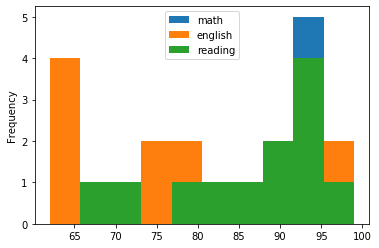

In [35]:
df.set_index('classroom').plot.hist()

We'll revisti the concept of indices in more depth when we talk about time series data, but it is good to be familar with the concept now. 

### .pipe

The `.pipe` method allows chains of functions that accept and return dataframes to be applied to a dataframe, and extra arguments to those functions t obe specified.

In [36]:
def calculate_avg_grade(df):
    avg = (df.math + df.english + df.reading) / 3
    return df.assign(average_grade=avg)

df.pipe(calculate_avg_grade)

,name,math,english,reading,classroom,passing_math,average_grade
0,Sally,62,85,80,A,failing,75.666667
1,Jane,88,79,67,B,passing,78.000000
2,Suzie,94,74,95,A,passing,87.666667
3,Billy,98,96,88,B,passing,94.000000
4,Ada,77,92,98,A,passing,89.000000
5,John,79,76,93,B,passing,82.666667
6,Thomas,82,64,81,A,passing,75.666667
7,Marie,93,63,90,A,passing,82.000000
8,Albert,92,62,87,A,passing,80.333333
9,Richard,69,80,94,A,failing,81.000000


### `.loc` and `.iloc`

We can use `.iloc` to subset rows or columns using a numerical index. For example to select the first 3 rows:

In [37]:
df.iloc[:3]

,name,math,english,reading,classroom,passing_math
0,Sally,62,85,80,A,failing
1,Jane,88,79,67,B,passing
2,Suzie,94,74,95,A,passing


We can also specify which columns we want to select:

In [38]:
df.iloc[:3, 1:3]

,math,english
0,62,85
1,88,79
2,94,74


Here we select the first 3 rows (everything up to but not including the index of 3), and the second and third columns (starting from the index of 1 up to but not including the index of 3).

Similarly, `.loc` let us obtain values by a named index:

In [39]:
df.loc[:,'math':'reading'].head(4)

,math,english,reading
0,62,85,80
1,88,79,67
2,94,74,95
3,98,96,88


The above code asks pandas for all of the rows from the dataframe(`:`), and all of the columns from `math` to `reading`. From the resulting dataframe, we call the `.head` method to get the first 4 rows.

### Transposing

In [40]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11
name,Sally,Jane,Suzie,Billy,Ada,John,Thomas,Marie,Albert,Richard,Isaac,Alan
math,62,88,94,98,77,79,82,93,92,69,92,92
english,85,79,74,96,92,76,64,63,62,80,99,62
reading,80,67,95,88,98,93,81,90,87,94,93,72
classroom,A,B,A,B,A,B,A,A,A,A,B,A
passing_math,failing,passing,passing,passing,passing,passing,passing,passing,passing,failing,passing,passing


# Class Discussion

In [41]:
data = np.array([[1, 2, 3], [4, 5, 6]])

pd.DataFrame(data, columns=['a', 'b', 'c'])

,a,b,c
0,1,2,3
1,4,5,6


For the example above, the column's label helps ensure that there are structure columns we can reference later, the only issue is that if we skip this, then pandas will do a random set of numbers which aren't correlated.

In [49]:
# quotes = pd.read_json("quotes.json")
# quotes.head()

The example above shows how Ryan was able to pull a JSON file from his own directory. Because I don't have the JSON file in my directory, then I can't run the code, but it is a good example of the correct syntax. This syntax is similar when using any of the other `.read_` functions with other files, like `txt`, `csv`, or even `.xlsx`

.CSV stands for "comma separeted value" == excel exports, hoohle sheets
- Datasets we get from someone
- export your contacts from your contacts manager

JSON is a data interchange format (how we send data)
* Javascript object notation == exacly the same as python lists/dictionary syntax
* python dictionary == js object

How do we write to a CVS file?

In [43]:
from pydataset import data
mpg = data("mpg")

In [44]:
#mpg.to_csv("mpg.csv")

# This code will actually turn a dataframe into a CSV. This is super useful when it comes to sharing this data with 
# other people that might not necesarly have python or even pandas.

## Using `pd.read_sql()`

In [45]:
from env import host, user, password
db_name = "employees"
url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [46]:
df = pd.read_sql("SELECT * FROM employees LIMIT 5", url)

In [47]:
df

,emp_no,birth_date,first_name,last_name,gender,hire_date
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01
4,10005,1955-01-21,Kyoichi,Maliniak,M,1989-09-12


## Groupby

In [53]:
np.random.seed(123)

students = ['Sally', 'Jane', 'Suzie', 'Billy', 'Ada', 'John', 'Thomas',
            'Marie', 'Albert', 'Richard', 'Isaac', 'Alan']

# randomly generate scores for each student for each subject
# note that all the values need to have the same length here
math_grades = np.random.randint(low=60, high=100, size=len(students))
english_grades = np.random.randint(low=60, high=100, size=len(students))
reading_grades = np.random.randint(low=60, high=100, size=len(students))

class_grades = pd.DataFrame({'name': students,
                   'math': math_grades,
                   'english': english_grades,
                   'reading': reading_grades,
                   'classroom': np.random.choice(['A', 'B'], len(students))})

In [54]:
class_grades.groupby("classroom").reading.median()

classroom
A    88.5
B    90.5
Name: reading, dtype: float64

# Exercises

Create a notebook or python script named 4.8.4.4_advanced_dataframes to do your work in for this exercise.

For the following exercises, you'll need to load several datasets using the pydataset library. (If you get an error when trying to run the import below, use pip to install the pydataset package.)

In [48]:
from pydataset import data

When the instructions say to load a dataset, you can pass the name of the dataset as a string to the data function to load the dataset. You can also view the documentation for the data set by passing the show_doc keyword argument.

## Exercise 1

Load the mpg dataset. Read the documentation for it, and use the data to answer these questions:

In [ ]:
mpg = data('mpg')

In [ ]:
mpg.head(10)

### On average, which manufacturer has the best miles per gallon?

In [ ]:
mpg["average_mileage"] = (mpg.hwy + mpg.cty) / 2

In [ ]:
mpg.nlargest(1, "average_mileage", keep = "all")

### How many different manufacturers are there?

In [ ]:
mpg["manufacturer"].unique().size

### How many different models are there?

In [ ]:
mpg['model'].unique().size

### Do automatic or manual cars have better miles per gallon?

In [ ]:
mpg.groupby('trans').average_mileage.mean().sort_values(ascending =False)

## Exercise 2 Joining and Merging

Copy the users and roles dataframes from the examples above. What do you think a right join would look like? An outer join? What happens if you drop the foreign keys from the dataframes and try to merge them?

In [ ]:
users = pd.DataFrame({
    'id': [1, 2, 3, 4, 5, 6],
    'name': ['bob', 'joe', 'sally', 'adam', 'jane', 'mike'],
    'role_id': [1, 2, 3, 3, np.nan, np.nan]
})
users

In [ ]:
roles = pd.DataFrame({
    'id': [1, 2, 3, 4],
    'name': ['admin', 'author', 'reviewer', 'commenter']
})
roles

In [ ]:
pd.merge(users, roles, left_on="role_id", right_on="id", how="right")

With a right join, we get the users role to match whatever exists on the 'roles' array. Thus means that from doing a right join, we wouldn't get any 'users' that don't current have a role, like Jane and Mike

In [ ]:
pd.merge(users, roles, left_on="role_id", right_on="id", how="outer")

An outer join actually combines all the values in both tables, despite NaN dtypes.

## Exercise 3 Getting Data from SQL databses

Create a function named get_db_url. It should accept a username, hostname, password, and database name and return a url formatted like in the examples in this lesson.

In [57]:
def get_db_url(username,hostname,password,database_name):
    url = f"mysql+pymysql://{username}:{password}@{hostname}/{databse_name}"
    return url

Use your function to obtain a connection to the employees database.

In [58]:
from env import host, user, password
db_name = "employees"
url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'
query = 'SELECT * FROM employees'
employees = pd.read_sql(query,url)

Intentionally make a typo in the database url. What kind of error message do you see?

`OperationalError: (pymysql.err.OperationalError) (1045, "Access denied for user 'curie_942Z2gFYuyaDqB4s6cD6Q7vBvA8GqLcdSXB'@'97.105.19.58' (using password: NO)")
(Background on this error at: http://sqlalche.me/e/e3q8)`

Intentionally make an error in your SQL query. What does the error message look like?

`ProgrammingError: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'FRO employees' at line 1")
[SQL: SELECT * FRO employees]
(Background on this error at: http://sqlalche.me/e/f405)`

Read the employees and titles tables into two separate dataframes

In [59]:
query_titles = 'SELECT * FROM titles'
titles = pd.read_sql(query_titles,url)

In [60]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443308 entries, 0 to 443307
Data columns (total 4 columns):
emp_no       443308 non-null int64
title        443308 non-null object
from_date    443308 non-null object
to_date      443308 non-null object
dtypes: int64(1), object(3)
memory usage: 13.5+ MB


In [61]:
titles.head(5)

,emp_no,title,from_date,to_date
0,10001,Senior Engineer,1986-06-26,9999-01-01
1,10002,Staff,1996-08-03,9999-01-01
2,10003,Senior Engineer,1995-12-03,9999-01-01
3,10004,Engineer,1986-12-01,1995-12-01
4,10004,Senior Engineer,1995-12-01,9999-01-01


In [161]:
active = titles.to_date == titles.to_date.max() 

In [162]:
active_titles = titles[active]

Visualize the number of employees with each title.

In [322]:
title_count = active_titles.groupby("title").emp_no.agg("count")

In [323]:
title_count

title
Assistant Engineer     3588
Engineer              30983
Manager                   9
Senior Engineer       85939
Senior Staff          82024
Staff                 25526
Technique Leader      12055
Name: emp_no, dtype: int64

Text(0, 0.5, 'N of employees')

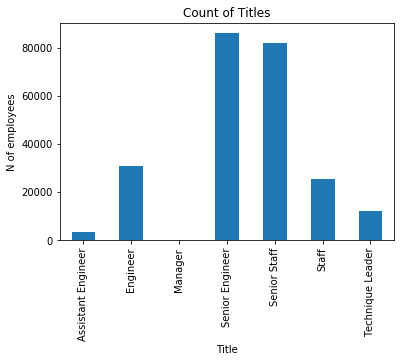

In [168]:
title_count.plot.bar()
plt.title("Count of Titles")
plt.xlabel("Title")
plt.ylabel("N of employees")

Join the employees and titles dataframes together.

In [62]:
employee_w_title = pd.merge(employees, titles, left_on="emp_no", right_on="emp_no", how="left")

Visualize how frequently employees change titles.

In [63]:
inactive_employees = employee_w_title['to_date'] != employee_w_title['to_date'].max()


In [64]:
old_roles = employee_w_title[inactive_employees]

# Filter out employees that currently have a job by removing to_date = 9999

In [65]:
old_role_w_dates = old_roles.astype({"to_date": 'datetime64', "from_date":'datetime64'}) 

# Need to change the data type to "date" so that I can compare how long employee stay in role

In [66]:
old_role_w_dates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203184 entries, 3 to 443306
Data columns (total 9 columns):
emp_no        203184 non-null int64
birth_date    203184 non-null object
first_name    203184 non-null object
last_name     203184 non-null object
gender        203184 non-null object
hire_date     203184 non-null object
title         203184 non-null object
from_date     203184 non-null datetime64[ns]
to_date       203184 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 15.5+ MB


In [154]:
old_role_w_dates = old_role_w_dates.assign(role_length = (old_role_w_dates.to_date - old_role_w_dates.from_date) /np.timedelta64(1,"Y"))

# Create new column looking at the difference between roles, it comes out in days, so I added a function at the end to turn into number of years

In [313]:
peak = old_role_w_dates.emp_no == 10009

In [314]:
old_role_w_dates[peak]

# Sample Test

,emp_no,birth_date,first_name,last_name,gender,hire_date,title,from_date,to_date,role_length
11,10009,1952-04-19,Sumant,Peac,F,1985-02-18,Assistant Engineer,1985-02-18,1990-02-18,4.999418
12,10009,1952-04-19,Sumant,Peac,F,1985-02-18,Engineer,1990-02-18,1995-02-18,4.999418


In [327]:
pivot_table_title = old_role_w_dates.pivot_table(values="role_length", index="emp_no", columns="title", aggfunc='mean')

In [329]:
pivot_table_title.sample(20)

title,Assistant Engineer,Engineer,Manager,Senior Engineer,Senior Staff,Staff,Technique Leader
emp_no,,,,,,,
401417,NaN,7.000828,NaN,NaN,NaN,NaN,NaN
427056,NaN,NaN,NaN,NaN,NaN,4.999418,NaN
254064,NaN,NaN,NaN,NaN,13.465027,NaN,NaN
30984,7.000828,NaN,NaN,NaN,NaN,NaN,NaN
425884,NaN,NaN,NaN,2.442213,NaN,NaN,NaN
19037,NaN,5.998754,NaN,NaN,NaN,NaN,NaN
291773,NaN,4.999418,NaN,9.453993,NaN,NaN,NaN
33451,NaN,NaN,NaN,NaN,NaN,1.779640,NaN
252761,NaN,8.999500,NaN,NaN,NaN,NaN,NaN


In [325]:
old_role_w_dates.groupby('emp_no')['title', 'role_length'].mean()

,role_length
emp_no,
10004,8.999500
10005,7.000828
10007,7.000828
10008,2.390193
10009,4.999418
...,...
499992,4.999418
499994,0.676263
499996,5.998754


In [317]:
title_length = old_role_w_dates.groupby('title').role_length.mean().sort_values(ascending=False)

In [159]:
title_length

title
Senior Staff          4.053200
Senior Engineer       4.101653
Manager               4.721794
Technique Leader      4.834544
Engineer              6.003088
Assistant Engineer    6.040345
Staff                 6.071924
Name: role_length, dtype: float64

Text(0, 0.5, 'Years')

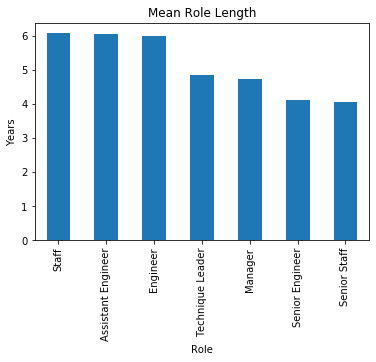

In [318]:
title_length.plot.bar()
plt.title("Mean Role Length")
plt.xlabel("Role")
plt.ylabel("Years")

In [330]:
#New question is to see how mean compares by department. I can either plot different chart

In [337]:
from env import host, user, password
db_name = "employees"
url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'
query = '''
SELECT title, dept_name, emp_no, titles.from_date, titles.to_date FROM titles
JOIN employees USING (emp_no)
JOIN dept_emp USING (emp_no)
JOIN departments USING (dept_no)
WHERE titles.to_date != "9999-01-01" AND dept_emp.to_date != "9999-01-01"
'''
titles_by_dept_count = pd.read_sql(query,url)

In [343]:
titles_by_dept = titles_by_dept_count.astype({"to_date": 'datetime64', "from_date":'datetime64'}) 

In [347]:
titles_by_dept = titles_by_dept.assign(delta = (titles_by_dept.to_date - titles_by_dept.from_date) /np.timedelta64(1,"Y"))

In [348]:
titles_by_dept.head()

,title,dept_name,emp_no,from_date,to_date,delta
0,Staff,Customer Service,10011,1990-01-22,1996-11-09,6.798223
1,Engineer,Customer Service,10098,1985-05-13,1992-05-13,7.000828
2,Senior Engineer,Customer Service,10098,1992-05-13,1992-12-11,0.580436
3,Staff,Customer Service,10115,1988-03-03,1992-05-24,4.224591
4,Senior Staff,Customer Service,10259,1993-07-24,1999-01-06,5.453911


In [351]:
mean_table = titles_by_dept.pivot_table(values="delta", index='title', columns="dept_name")

In [356]:
mean_table

dept_name,Customer Service,Development,Finance,Human Resources,Marketing,Production,Quality Management,Research,Sales
title,,,,,,,,,
Assistant Engineer,3.745126,4.564727,NaN,NaN,NaN,4.552312,4.348839,3.095557,NaN
Engineer,3.940138,4.520978,NaN,NaN,NaN,4.487612,4.439165,3.902569,NaN
Senior Engineer,4.184631,4.109120,NaN,NaN,NaN,4.111027,4.145788,4.020779,NaN
Senior Staff,4.083805,3.785292,3.993638,4.013812,4.074372,4.177096,NaN,3.987216,4.094274
Staff,4.482270,4.072377,4.622467,4.552299,4.452548,3.787123,NaN,4.650133,4.562470
Technique Leader,4.498140,4.882675,NaN,NaN,NaN,4.822492,4.707783,5.235753,NaN


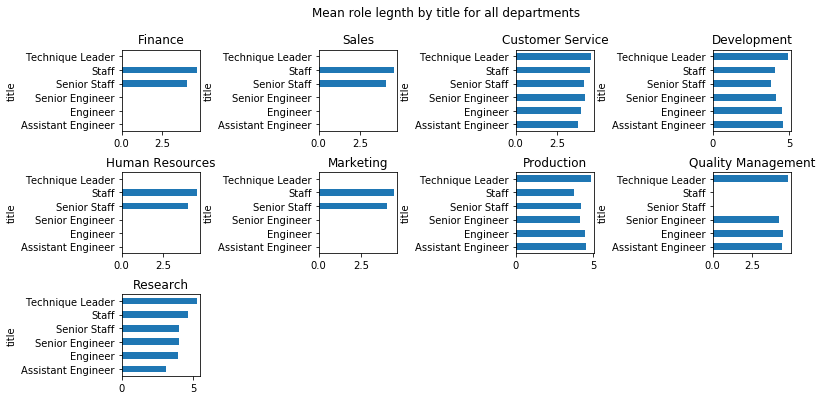

In [409]:
plt.figure(figsize=(12,6))

plt.subplot(3,4,1)
mean_table["Finance"].plot.barh()
plt.title("Finance")

plt.subplot(3,4,2)
mean_table["Sales"].plot.barh()
plt.title("Sales")

plt.subplot(3,4,3)
mean_table["Customer Service"].plot.barh()
plt.title("Customer Service")

plt.subplot(3,4,4)
mean_table["Development"].plot.barh()
plt.title("Development")

plt.subplot(3,4,5)
mean_table["Human Resources"].plot.barh()
plt.title("Human Resources")

plt.subplot(3,4,6)
mean_table["Marketing"].plot.barh()
plt.title("Marketing")

plt.subplot(3,4,7)
mean_table["Production"].plot.barh()
plt.title("Production")

plt.subplot(3,4,8)
mean_table["Quality Management"].plot.barh()
plt.title("Quality Management")

plt.subplot(3,4,9)
mean_table["Research"].plot.barh()
plt.title("Research")

plt.suptitle("Mean role legnth by title for all departments")

plt.subplots_adjust(wspace=1.5, hspace= .5)


Text(0, 0.5, 'Years')

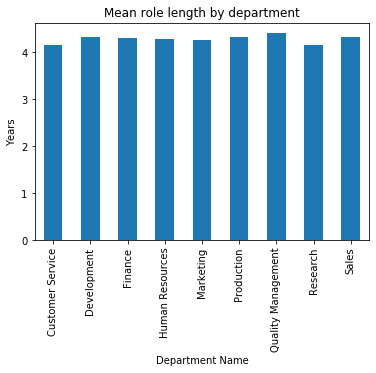

In [359]:
mean_table.mean().plot.bar()
plt.title("Mean role length by department")
plt.xlabel("Department Name")
plt.ylabel("Years")

For each title, find the hire date of the employee that was hired most recently with that title.

In [177]:
employee_w_title.head(5)

,emp_no,birth_date,first_name,last_name,gender,hire_date,title,from_date,to_date
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26,Senior Engineer,1986-06-26,9999-01-01
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21,Staff,1996-08-03,9999-01-01
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28,Senior Engineer,1995-12-03,9999-01-01
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,Engineer,1986-12-01,1995-12-01
4,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,Senior Engineer,1995-12-01,9999-01-01


In [180]:
employee_w_title = employee_w_title.astype({"hire_date": 'datetime64'}) 

In [186]:
pd.to_datetime('today')

Timestamp('2020-03-05 15:38:09.228304')

In [195]:
employee_w_title = employee_w_title.assign(days_since_hired = pd.to_datetime("today") - employee_w_title.hire_date)

In [200]:
employee_w_title.head(5)

,emp_no,birth_date,first_name,last_name,gender,hire_date,title,from_date,to_date,days_since_hired
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26,Senior Engineer,1986-06-26,9999-01-01,12306 days 15:43:45.886133
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21,Staff,1996-08-03,9999-01-01,12523 days 15:43:45.886133
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28,Senior Engineer,1995-12-03,9999-01-01,12243 days 15:43:45.886133
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,Engineer,1986-12-01,1995-12-01,12148 days 15:43:45.886133
4,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,Senior Engineer,1995-12-01,9999-01-01,12148 days 15:43:45.886133


In [206]:
employee_w_title.groupby('title')['emp_no','hire_date'].max()

## I was trying to be clever, and created a new column that showed days_since_hired, and then I was going to group 
## by however had the smallest difference, but I could just do max instead on the hire date

,emp_no,hire_date
title,,
Assistant Engineer,499974,1999-12-24
Engineer,499999,2000-01-28
Manager,111939,1992-02-05
Senior Engineer,499997,2000-01-01
Senior Staff,499998,2000-01-13
Staff,499998,2000-01-12
Technique Leader,499942,1999-12-31


Write the code necessary to create a cross tabulation of the number of titles by department. (Hint: this will involve a combination of SQL and python/pandas code)

In [210]:
from env import host, user, password
db_name = "employees"
url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'
query = '''
SELECT title, dept_name FROM titles
JOIN employees USING (emp_no)
JOIN dept_emp USING (emp_no)
JOIN departments USING (dept_no)
WHERE titles.to_date > NOW() AND dept_emp.to_date > NOW()
'''
titles_by_dept = pd.read_sql(query,url)

In [211]:
titles_by_dept.head(5)

,title,dept_name
0,Senior Staff,Customer Service
1,Senior Staff,Customer Service
2,Senior Staff,Customer Service
3,Senior Staff,Customer Service
4,Staff,Customer Service


In [212]:
pd.crosstab(titles_by_dept.title, titles_by_dept.dept_name)

dept_name,Customer Service,Development,Finance,Human Resources,Marketing,Production,Quality Management,Research,Sales
title,,,,,,,,,
Assistant Engineer,68,1652,0,0,0,1402,389,77,0
Engineer,627,14040,0,0,0,12081,3405,830,0
Manager,1,1,1,1,1,1,1,1,1
Senior Engineer,1790,38816,0,0,0,33625,9458,2250,0
Senior Staff,11268,1085,9545,9824,11290,1123,0,9092,28797
Staff,3574,315,2891,3073,3551,349,0,2870,8903
Technique Leader,241,5477,0,0,0,4723,1293,321,0


## Exercise 4. 
Use your get_db_url function to help you explore the data from the chipotle database. Use the data to answer the following questions:

In [247]:
from env import host, user, password
db_name = "chipotle"
url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'
query = '''
SELECT * FROM orders
'''
chipotle = pd.read_sql(query,url)

In [248]:
chipotle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4622 entries, 0 to 4621
Data columns (total 6 columns):
id                    4622 non-null int64
order_id              4622 non-null int64
quantity              4622 non-null int64
item_name             4622 non-null object
choice_description    4622 non-null object
item_price            4622 non-null object
dtypes: int64(3), object(3)
memory usage: 216.8+ KB


In [249]:
chipotle.sample(10)

,id,order_id,quantity,item_name,choice_description,item_price
4536,4537,1803,1,Steak Burrito,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice, Cheese]]",$9.25
1621,1622,654,1,Chicken Salad Bowl,"[Roasted Chili Corn Salsa, [Fajita Vegetables, Rice, Cheese, Lettuce]]",$8.75
3611,3612,1446,1,Chips and Guacamole,nan,$4.45
1839,1840,745,1,Chicken Bowl,"[[Roasted Chili Corn Salsa (Medium), Tomatillo-Red Chili Salsa (Hot), Fresh Tomato Sal...",$8.49
2583,2584,1025,1,Chips and Guacamole,nan,$3.99
2877,2878,1143,1,Chips and Tomatillo Red Chili Salsa,nan,$2.95
4404,4405,1757,1,Bottled Water,nan,$1.50
1648,1649,666,1,Barbacoa Burrito,"[Fresh Tomato (Mild), [Guacamole, Rice, Black Beans]]",$11.08
386,387,167,1,Side of Chips,nan,$1.69
3567,3568,1431,1,Chips,nan,$2.15


In [250]:
chipotle["item_price"] = chipotle.item_price.str.replace("$",'').astype("float")

In [251]:
chipotle.head()

,id,order_id,quantity,item_name,choice_description,item_price
0,1,1,1,Chips and Fresh Tomato Salsa,nan,2.39
1,2,1,1,Izze,[Clementine],3.39
2,3,1,1,Nantucket Nectar,[Apple],3.39
3,4,1,1,Chips and Tomatillo-Green Chili Salsa,nan,2.39
4,5,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans, Rice, Cheese, Sour Cream]]",16.98


What is the total price for each order?

In [254]:
chipotle = chipotle.assign(i_item_price = chipotle.item_price / chipotle.quantity)

In [290]:
chipotle.groupby("item_name").i_item_price.max().sort_values(ascending=False)

item_name
Barbacoa Salad Bowl                      11.89
Steak Salad Bowl                         11.89
Carnitas Salad Bowl                      11.89
Steak Burrito                            11.75
Steak Bowl                               11.75
Carnitas Crispy Tacos                    11.75
Barbacoa Soft Tacos                      11.75
Carnitas Soft Tacos                      11.75
Barbacoa Crispy Tacos                    11.75
Barbacoa Burrito                         11.75
Barbacoa Bowl                            11.75
Carnitas Burrito                         11.75
Carnitas Bowl                            11.75
Steak Crispy Tacos                       11.75
Steak Soft Tacos                         11.75
Veggie Salad Bowl                        11.25
Chicken Soft Tacos                       11.25
Chicken Salad Bowl                       11.25
Chicken Crispy Tacos                     11.25
Chicken Burrito                          11.25
Veggie Soft Tacos                        11.25
Chi

What are the most popular 3 items?

In [283]:
top_3 = chipotle.groupby("item_name").quantity.sum().sort_values(ascending = False).head(3)

Text(0, 0.5, 'Number of Orders')

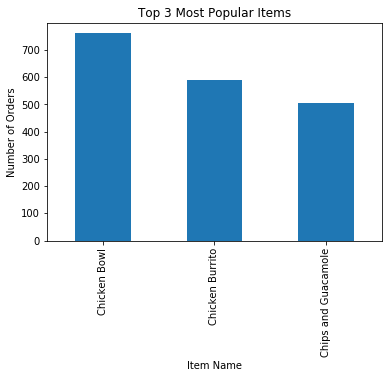

In [287]:
top_3.plot.bar()
plt.title("Top 3 Most Popular Items")
plt.xlabel("Item Name")
plt.ylabel("Number of Orders")

Which item has produced the most revenue?

In [276]:
chipotle.groupby("item_name").item_price.sum().sort_values().tail(1)

item_name
Chicken Bowl    7342.73
Name: item_price, dtype: float64